In [1]:
#import all packages
import heapq
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [3]:
class Queue():
    """This class handles a queue. It holds data for the history of the queue,
    which is the queue length when each customer arrives to it, when they departure, and the length
    when a customer arrives"""
    
    #Defined the data that the instance should hold
    def __init__(self, service_rate):
        self.history = [] #history of the queue
        self.length = 0
        self.service_time = 1/service_rate #service rate
    
    #initialize the service of one customer
    def service_customer(self, schedule):
        #start the service of the customer i.e. schedules new event departure_customer
        schedule.add_event_after(self.service_time, self.departure_customer)
    
    #depart a customer after they've been served
    def departure_customer(self, schedule):
        
        #update the departure time for the customer
        self.history[-self.length][2] = schedule.now
        
        #depart 1 customer
        self.length -= 1
        
        #if there is a queue, add a new customer to t
        if self.length > 0:
            self.service_customer(schedule)

class GroceryStore():
    """This class is the grocery store and hold the queue. 
    This class also handles the arrivals to the store"""
    
    #Defined the data that the instance should hold
    def __init__(self, arrival_rate, service_rate):
        self.arrival_rate = arrival_rate #arrival rate
        self.queue = Queue(service_rate) #creates a queue for the GroceryStore

    
    #This method adds an event that is add_to_queue to the scheduler
    def arrival_time_customer(self, schedule):
        
        #find the distance to next arrival from a exponential distribution
        interval = sts.expon.rvs(scale = 1/self.arrival_rate)
        
        #adds the arrival event with the arrival interval to the schedule
        schedule.add_event_after(interval, self.add_to_queue)
    
    def add_to_queue(self, schedule):
        
        #appends a new customer to the queue, 
        #arg: historical_position, time of arrival, None (placeholder for departure time)
        self.queue.history.append([self.queue.length + 1, schedule.now, None])
        
        #increase the queue length by 1
        self.queue.length += 1
        
        #schedule new arrival
        self.arrival_time_customer(schedule)
        
        #if the queue only has one customer that just arrived, schedule the service
        if self.queue.length == 1:
            self.queue.service_customer(schedule)


In [4]:
def run_simulation(arrival_rate, service_rate, run_until):
    """This function runs the simulation and has access to all the instances of GroceryStore & Queue"""
    
    #creates a GroceryStore instance
    Grocery_Store = GroceryStore(arrival_rate, service_rate)
    
    #creates a Schedule instance
    schedule = Schedule()
    
    #Schedules a new customer (assumes no customer came early and waits outside the store)
    Grocery_Store.arrival_time_customer(schedule)
    
    #runs the simulation
    while schedule.now < run_until:
        
        #runs the next event
        schedule.run_next_event()
    
    #returns the queue data
    return Grocery_Store.queue.history
    

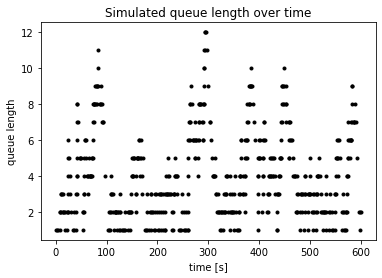

In [5]:
arrival_rate = 1
service_rate = 1.1
run_until = 600 #10 hours

#the data to be plotted
plot_data = run_simulation(arrival_rate, service_rate, run_until)

#the queue length and the arrival times
x_val = [datum[1] for datum in plot_data]
y_val = [datum[0] for datum in plot_data]

#plots the simulation
plt.figure()
plt.title('Simulated queue length over time')
plt.plot(x_val, y_val, 'k.')
plt.xlabel('time [s]')
plt.ylabel('queue length')
plt.show()

In [6]:
print(sum(y_val)/len(y_val))
print((arrival_rate/service_rate)**2/(2*(1-arrival_rate/service_rate)))

4.109777015437393
4.545454545454543


In the most recent simulation with a utilization of approximatly 0.9, we would expect an average queue length of around 4.5. This agrees fairly well with our simulation as the average queue length is around 4.1

#PythonImplementation: The described model was implemented using the scheduling heuristic. The simulation lets the user define relevant parameters and outputs appropriate data_viz displaying the state of the simulation at any given time. The data visualization appears as a continuous plot displaying the queue length throughout the simulation. 
The chosen data structure for storing the data of the simulation was regular lists since they allowed for modification (needed with an update of departure time). In the code, I've also provided 1 test that shows how the simulation operates close to what theory predicts. 
#CodeReadability: The code is well documented allowing the user(s) to follow along with the code. Variables are named appropriately (i.e. service_rate vs service_time). All methods are implemented under the relevant classes. 
